# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import Shrec17DeepSphere as shrecDataset
from SHREC17.load_shrec import fix_dataset

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 3        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
download = False
train_dataset = shrecDataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)


31364it [02:08, 243.36it/s]


In [8]:
val_dataset = shrecDataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

5133it [00:21, 236.60it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


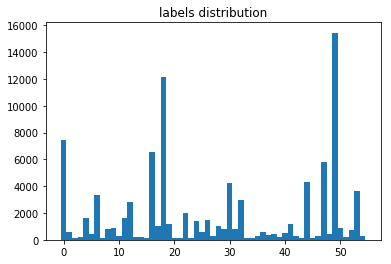

In [12]:
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [13]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
#ids = train_dataset.retrieve_ids()
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 94092 
first id: 001929


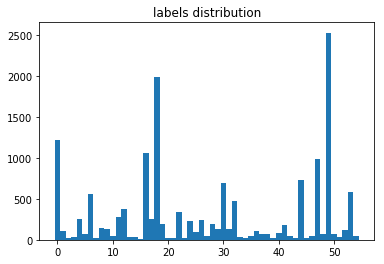

In [14]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [15]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

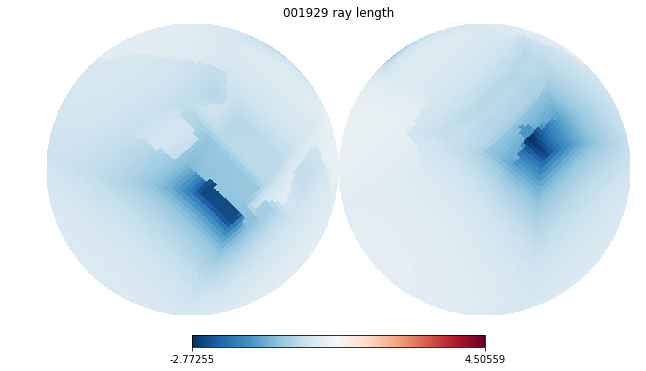

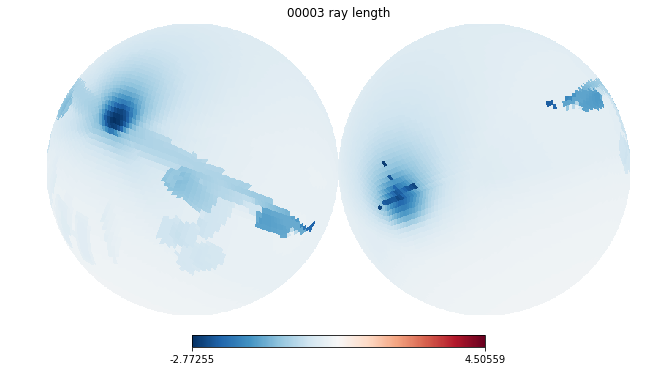

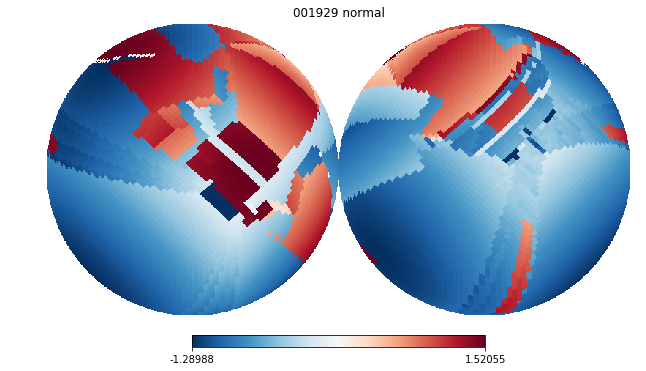

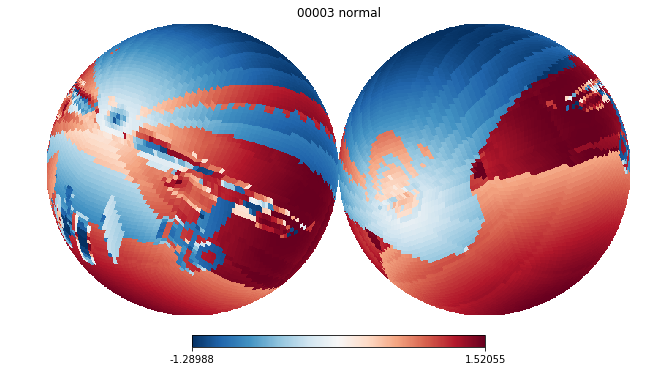

In [16]:
hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [17]:
#training = LabeledDatasetWithNoise(x_train, labels_train, end_level=sigma_noise)
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [18]:
#EXP_NAME = 'shrec17_Cohen_simple_reg_5K_more_{}sides_{}noise{}'.format(Nside, sigma_noise, ename)
EXP_NAME = 'shrec17_Cohen_simple_SGD_max_K5_aug_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [49]:
params = hyperparameters.get_params_shrec17(training.N, EXP_NAME, Nside, train_dataset.nclass, architecture=experiment_type)
model = models.deepsphere(**params)

#sides: [32, 8, 4]
#pixels: [12288, 768, 192]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 38,540,083,200
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [34]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [18]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.35e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.45 (23 / 5133), f1 (weighted): 0.28, loss: 4.20e+00
  CPU time: 247s, wall time: 976s, perf_time: 0.62s
step 2940 / 19602 (epoch 3.00 / 20):
  learning_rate = 3.16e-05, training loss = 3.72e+00
  validation accuracy: 3.37 (173 / 5133), f1 (weighted): 2.86, loss: 3.97e+00
  CPU time: 470s, wall time: 1889s, perf_time: 0.56s
step 4410 / 19602 (epoch 4.50 / 20):
  learning_rate = 1.78e-04, training loss = 3.29e+00
  validation accuracy: 31.09 (1596 / 5133), f1 (weighted): 19.99, loss: 3.17e+00
  CPU time: 686s, wall time: 2769s, perf_time: 0.57s
step 5880 / 19602 (epoch 6.00 / 20):
  learning_rate = 9.98e-04, training loss = 2.18e+00
  validation accuracy: 45.22 (2321 / 5133), f1 (weighted): 33.98, loss: 2.36e+00
  CPU time: 901s, wall time: 3648s, perf_time: 0.56s
step 7350 / 19602 (epoch 7.50 / 20):
  learning_rate = 5.61e-03, training loss = 1.69e+00
  validation accuracy: 57.72 (2963 / 5133), f1 (weighted): 50.28, loss: 1.77e+00
  CPU time: 1118s, wall time: 4

KeyboardInterrupt: 

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [35]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 58,700


In [ ]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training loss = 5.04e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 66.32 (3404 / 5133), f1 (weighted): 63.38, loss: 1.30e+00
  CPU time: 112s, wall time: 331s, perf_time: 0.56s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 5.00e-01, training loss = 9.51e-01
  validation accuracy: 66.86 (3432 / 5133), f1 (weighted): 64.22, loss: 1.24e+00
  CPU time: 220s, wall time: 659s, perf_time: 0.58s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.99e-01
  validation accuracy: 70.89 (3639 / 5133), f1 (weighted): 68.69, loss: 1.13e+00
  CPU time: 328s, wall time: 986s, perf_time: 0.58s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 5.00e-01, training loss = 7.77e-01
  validation accuracy: 70.99 (3644 / 5133), f1 (weighted): 68.73, loss: 1.11e+00
  CPU time: 433s, wall time: 1312s, perf_time: 0.58s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 5.00e-01, training loss = 6.53e-01
  validation accuracy: 73.35 (3765 / 5133), f1 (weighted): 71.41, loss: 1.05e+00
  CPU time: 539s, wall 

step 18620 / 98012 (epoch 19.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.41e-01
  validation accuracy: 77.89 (3998 / 5133), f1 (weighted): 76.66, loss: 9.17e-01
  CPU time: 4009s, wall time: 12396s, perf_time: 0.58s
step 19110 / 98012 (epoch 19.50 / 100):
  learning_rate = 5.00e-01, training loss = 1.46e-01
  validation accuracy: 76.45 (3924 / 5133), f1 (weighted): 75.77, loss: 9.58e-01
  CPU time: 4113s, wall time: 12722s, perf_time: 0.58s
step 19600 / 98012 (epoch 20.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.56e-01
  validation accuracy: 77.85 (3996 / 5133), f1 (weighted): 76.57, loss: 9.32e-01
  CPU time: 4218s, wall time: 13048s, perf_time: 0.58s
step 20090 / 98012 (epoch 20.50 / 100):
  learning_rate = 5.00e-01, training loss = 2.40e-01
  validation accuracy: 77.07 (3956 / 5133), f1 (weighted): 76.42, loss: 9.30e-01
  CPU time: 4323s, wall time: 13373s, perf_time: 0.58s
step 20580 / 98012 (epoch 21.00 / 100):
  learning_rate = 5.00e-01, training loss = 

step 36260 / 98012 (epoch 37.00 / 100):
  learning_rate = 5.00e-01, training loss = 5.79e-02
  validation accuracy: 79.12 (4061 / 5133), f1 (weighted): 78.47, loss: 9.04e-01
  CPU time: 7714s, wall time: 24095s, perf_time: 0.58s
step 36750 / 98012 (epoch 37.50 / 100):
  learning_rate = 5.00e-01, training loss = 9.13e-02
  validation accuracy: 78.57 (4033 / 5133), f1 (weighted): 78.11, loss: 9.05e-01
  CPU time: 7821s, wall time: 24420s, perf_time: 0.58s
step 37240 / 98012 (epoch 38.00 / 100):
  learning_rate = 5.00e-01, training loss = 6.19e-02
  validation accuracy: 78.51 (4030 / 5133), f1 (weighted): 78.02, loss: 9.26e-01
  CPU time: 7929s, wall time: 24747s, perf_time: 0.58s
step 37730 / 98012 (epoch 38.50 / 100):
  learning_rate = 5.00e-01, training loss = 8.03e-02
  validation accuracy: 78.36 (4022 / 5133), f1 (weighted): 77.91, loss: 9.25e-01
  CPU time: 8036s, wall time: 25073s, perf_time: 0.58s
step 38220 / 98012 (epoch 39.00 / 100):
  learning_rate = 5.00e-01, training loss = 

step 53900 / 98012 (epoch 54.99 / 100):
  learning_rate = 5.00e-01, training loss = 2.80e-02
  validation accuracy: 79.23 (4067 / 5133), f1 (weighted): 78.52, loss: 9.55e-01
  CPU time: 11608s, wall time: 35982s, perf_time: 0.58s
step 54390 / 98012 (epoch 55.49 / 100):
  learning_rate = 5.00e-01, training loss = 7.59e-02
  validation accuracy: 78.10 (4009 / 5133), f1 (weighted): 77.59, loss: 9.64e-01
  CPU time: 11716s, wall time: 36309s, perf_time: 0.58s
step 54880 / 98012 (epoch 55.99 / 100):
  learning_rate = 5.00e-01, training loss = 3.96e-02
  validation accuracy: 79.02 (4056 / 5133), f1 (weighted): 78.36, loss: 9.73e-01
  CPU time: 11827s, wall time: 36637s, perf_time: 0.58s
step 55370 / 98012 (epoch 56.49 / 100):
  learning_rate = 5.00e-01, training loss = 3.80e-02
  validation accuracy: 77.69 (3988 / 5133), f1 (weighted): 77.16, loss: 9.76e-01
  CPU time: 11938s, wall time: 36965s, perf_time: 0.58s
step 55860 / 98012 (epoch 56.99 / 100):
  learning_rate = 5.00e-01, training los

step 71540 / 98012 (epoch 72.99 / 100):
  learning_rate = 5.00e-01, training loss = 3.06e-02
  validation accuracy: 78.10 (4009 / 5133), f1 (weighted): 77.25, loss: 1.04e+00
  CPU time: 15590s, wall time: 47797s, perf_time: 0.59s
step 72030 / 98012 (epoch 73.49 / 100):
  learning_rate = 5.00e-01, training loss = 6.03e-02
  validation accuracy: 78.49 (4029 / 5133), f1 (weighted): 77.79, loss: 9.92e-01
  CPU time: 15700s, wall time: 48125s, perf_time: 0.59s
step 72520 / 98012 (epoch 73.99 / 100):
  learning_rate = 5.00e-01, training loss = 3.47e-02
  validation accuracy: 78.76 (4043 / 5133), f1 (weighted): 77.93, loss: 1.01e+00
  CPU time: 15811s, wall time: 48453s, perf_time: 0.58s
step 73010 / 98012 (epoch 74.49 / 100):
  learning_rate = 5.00e-01, training loss = 5.77e-02
  validation accuracy: 78.80 (4045 / 5133), f1 (weighted): 78.24, loss: 9.70e-01
  CPU time: 15921s, wall time: 48781s, perf_time: 0.59s
step 73500 / 98012 (epoch 74.99 / 100):
  learning_rate = 5.00e-01, training los

step 89180 / 98012 (epoch 90.99 / 100):
  learning_rate = 5.00e-01, training loss = 5.61e-02
  validation accuracy: 79.17 (4064 / 5133), f1 (weighted): 78.27, loss: 1.02e+00
  CPU time: 19572s, wall time: 59611s, perf_time: 0.58s
step 89670 / 98012 (epoch 91.49 / 100):
  learning_rate = 5.00e-01, training loss = 2.52e-02
  validation accuracy: 78.41 (4025 / 5133), f1 (weighted): 78.08, loss: 1.03e+00
  CPU time: 19683s, wall time: 59939s, perf_time: 0.58s
step 90160 / 98012 (epoch 91.99 / 100):
  learning_rate = 5.00e-01, training loss = 5.38e-02
  validation accuracy: 78.98 (4054 / 5133), f1 (weighted): 78.26, loss: 1.04e+00
  CPU time: 19793s, wall time: 60267s, perf_time: 0.58s
step 90650 / 98012 (epoch 92.49 / 100):
  learning_rate = 5.00e-01, training loss = 5.01e-02
  validation accuracy: 79.10 (4060 / 5133), f1 (weighted): 78.37, loss: 1.02e+00
  CPU time: 19904s, wall time: 60596s, perf_time: 0.58s
step 91140 / 98012 (epoch 92.99 / 100):
  learning_rate = 5.00e-01, training los

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [38]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN/model-98012


('accuracy: 86.60 (27162 / 31364), f1 (weighted): 86.44, loss: 4.37e-01\nCPU time: 58s, wall time: 52s',
 86.60247417421247,
 86.44316067880925,
 0.4369253905288359)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [39]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN/model-98012


('accuracy: 77.54 (3980 / 5133), f1 (weighted): 76.64, loss: 1.02e+00\nCPU time: 9s, wall time: 8s',
 77.53750243522308,
 76.63621165845726,
 1.0162802186598445)

In [23]:
repeat = val_dataset.repeat

In [42]:
probabilities = model.probs(x_val, nclass)
if repeat>1:
    probabilities = probabilities.reshape((-1,repeat,nclass))
    probabilities = repeat.mean(axis=1)
    #ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

In [43]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_SGD/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [19]:
test_dataset = shrecDataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=Nside, augmentation=augmentation, nfile=None)

10265it [00:54, 189.90it/s]


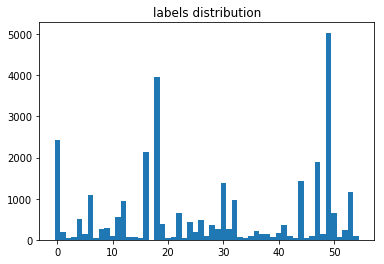

In [20]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [40]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN/model-98012


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 73.07 (7501 / 10265), f1 (weighted): 72.84, loss: 1.22e+00\nCPU time: 19s, wall time: 17s',
 73.07355090112031,
 72.84044301241279,
 1.2188190581911202)

In [ ]:
#predictions = model.predict(x_test)

In [44]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_Cohen_simple_SGD_max_32sides_CNN/model-98012


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [45]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_SGD/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_SGD/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [46]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

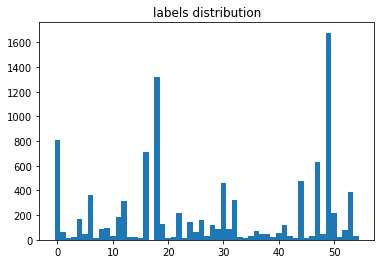

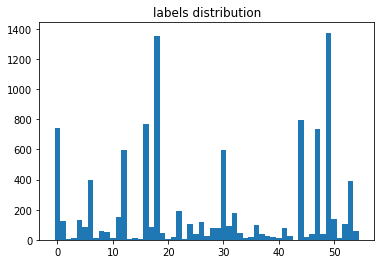

In [47]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)

In [25]:
del test_dataset
del train_dataset
del val_dataset

In [22]:
import tensorflow as tf
tf.reset_default_graph()